In [36]:
import gzip
import numpy as np
import structlog
from matplotlib import pyplot as plt
from dataclasses import dataclass
import random
from sklearn.metrics import accuracy_score

LOGGER = structlog.get_logger()

## Data Loading

In [2]:
IMAGES_TRAIN_PATH = "../data/train-images-idx3-ubyte.gz"
LABELS_TRAIN_PATH = "../data/train-labels-idx1-ubyte.gz"
IMAGES_TEST_PATH = "../data/t10k-images-idx3-ubyte.gz"
LABELS_TEST_PATH = "../data/t10k-labels-idx1-ubyte.gz"

In [3]:
from array import array
from struct import unpack


def parse_gzip(f):
    data_types = {
        0x08: "B",
        0x09: "b",
        0x0B: "h",
        0x0C: "i",
        0x0D: "f",
        0x0E: "d",
    }

    header = f.read(4)
    _, data_type_label, num_dimensions = unpack(">HBB", header)
    data_type_label = data_types[data_type_label]
    dimension_sizes = unpack(">" + "I" * num_dimensions, f.read(4 * num_dimensions))
    data = array(data_type_label, f.read())
    data.byteswap()

    return np.array(data).reshape(dimension_sizes)

In [4]:
def read_from_path(path: str) -> np.array:
    with gzip.open(path, "rb") as f:
        return parse_gzip(f)

In [5]:
train_images_raw = read_from_path(IMAGES_TRAIN_PATH)
train_labels = read_from_path(LABELS_TRAIN_PATH)
test_images_raw = read_from_path(IMAGES_TEST_PATH)
test_labels = read_from_path(LABELS_TEST_PATH)

In [6]:
LOGGER.info(f"train images: {len(train_images_raw)}")
LOGGER.info(f"train labels: {len(train_labels)}")
LOGGER.info(f"test images: {len(test_images_raw)}")
LOGGER.info(f"test labels: {len(test_labels)}")

TOTAL_SIZE = train_images_raw[0].size
DIMENSIONS = (len(train_images_raw[0]), len(train_images_raw[0]))

LOGGER.info(f"dimensions of image: {TOTAL_SIZE} {DIMENSIONS}")

LABELS = list(set(train_labels))
LOGGER.info(f"labels: {LABELS}")

2024-02-11 00:46:54 [info     ] train images: 60000           
2024-02-11 00:46:54 [info     ] train labels: 60000           
2024-02-11 00:46:54 [info     ] test images: 10000            
2024-02-11 00:46:54 [info     ] test labels: 10000            
2024-02-11 00:46:54 [info     ] dimensions of image: 784 (28, 28)
2024-02-11 00:46:54 [info     ] labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
MAX = max([max(t.flatten()) for t in train_images_raw])

train_images = train_images_raw / MAX
test_images = test_images_raw / MAX

LOGGER.info("normalised images")

2024-02-11 00:46:55 [info     ] normalised images             


In [ ]:
@dataclass
class Sample:
    image: np.array
    label: int


train = [Sample(image=train_images[i], label=train_labels[i]) for i in range(len(train_images))]

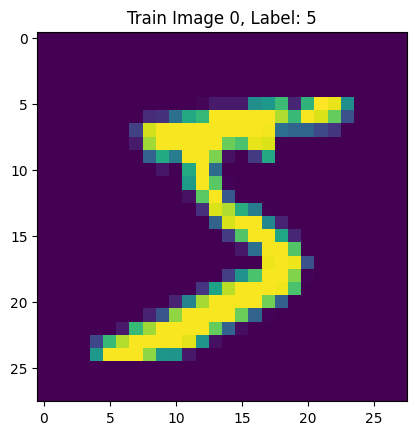

In [17]:
idx = 0
plt.imshow(train_images[idx])
plt.title(f"Train Image {idx}, Label: {train_labels[idx]}")
plt.show()

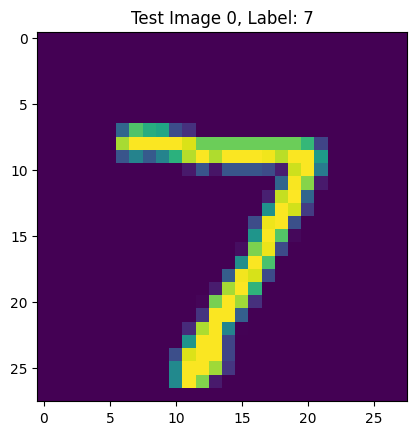

In [18]:
idx = 0
plt.imshow(test_images[idx])
plt.title(f"Test Image {idx}, Label: {test_labels[idx]}")
plt.show()

## Modelling

Given a layer of inputs $\vec{a_{i}}$, a matrix of weights $\vec{W_i}$, biases $\vec{b_i}$ and an activation function $\sigma$, the inputs fed forward to $\vec{a_{i+1}}$ are as follows:
$$\sigma \left( \vec{W_i}\vec{a_{i}} + \vec{b_i} \right)=\vec{a_{i+1}}$$

Cost function, for all weights $\vec{w}$, and for actual outputs $a^{(L)}$ and real outputs $y_i$ (for one such $k$ such that $y_k=1$, and $y_j=0  \forall j \neq k$):
$$C(\vec{w})=\Sigma_{i} (a^{(L)}_i - y_i)^2$$

Need to compute gradient descent step on a batch of the training data at a time (e.g. 10)

$$
\frac{\delta C_0}{\delta w^{(L)}}=\frac{\delta z^{(L)}}{\delta w^{(L)}}\frac{\delta a^{(L)}}{\delta z^{(L)}}\frac{\delta C_0}{\delta a^{(L)}}=2(a^{(L)}-y)\sigma' (z^{(L)})a^{(L-1)}
$$

In [10]:
def sigmoid(x: np.array) -> np.array:
    return 1 / (1 + np.exp(-x))


def sigmoid_deriv(x: np.array) -> np.array:
    return sigmoid(x) * (1 - sigmoid(x))


def output_error(a: np.array, y: np.array, z: np.array):
    return 2 * sigmoid_deriv(z) * (a - y)


def label_one_hot_encoded(label: int) -> np.array:
    y = np.zeros(len(LABELS))
    y[label] = 1
    return y

In [128]:
class Network:
    def __init__(self) -> None:
        self._l1_len = TOTAL_SIZE  # 784, input layer
        self._l2_len = 16  # hidden layer
        self._l3_len = 16  # hidden layer
        self._l4_len = len(LABELS)  # 10, final layer

        self._w1 = np.random.rand(self._l2_len, self._l1_len)

        bias_scale_factor = -36
        self._b1 = np.random.rand(self._l2_len) * bias_scale_factor

        self._w2 = np.random.rand(self._l3_len, self._l2_len)
        self._b2 = np.random.rand(self._l3_len)

        self._w3 = np.random.rand(self._l4_len, self._l3_len)
        self._b3 = np.random.rand(self._l4_len)

    def predict(self, x: np.array) -> int:
        _, _, _, _, _, a3 = self._forward_propagation(x)
        return np.argmax(a3)

    def _forward_propagation(self, x: np.array):
        z1 = np.matmul(self._w1, x) + self._b1
        a1 = sigmoid(z1)
        z2 = np.matmul(self._w2, a1) + self._b2
        a2 = sigmoid(z2)
        z3 = np.matmul(self._w3, a2) + self._b3
        a3 = sigmoid(z3)
        return z1, a1, z2, a2, z3, a3

    def train(self, samples: list[Sample]) -> list[float]:
        accuracies = []
        epochs = 300
        for epoch in range(epochs):
            accuracy = self._train_epoch(samples)
            accuracies += [accuracy]

            if epoch % int(epochs / 10) == 0:
                LOGGER.debug(f"finished epoch {epoch} with accuracy of {accuracy}")

        return accuracies

    def _train_epoch(self, samples: list[Sample]) -> float:
        batch_size = 100
        random.shuffle(samples)

        test_size = 0.1
        limit = int(len(samples) * test_size)
        test_samples = samples[:limit]
        train_samples = samples[limit:]

        batches = [
            train_samples[x : x + batch_size] for x in range(0, len(train_samples), batch_size)
        ]

        for _, batch in enumerate(batches):
            self._update_with_batch(batch)

        predictions = []
        labels = []
        for sample in test_samples:
            predicted = self.predict(sample.image.flatten())
            labels += [sample.label]
            predictions += [predicted]

        accuracy = accuracy_score(labels, predictions)
        return accuracy

    def _update_with_batch(self, batch: list[Sample]) -> None:
        learning_rate = 0.3

        nabla_b3_total = 0
        nabla_w3_total = 0
        nabla_b2_total = 0
        nabla_w2_total = 0
        nabla_b1_total = 0
        nabla_w1_total = 0

        for sample in batch:
            x = sample.image.flatten()

            z1, a1, z2, a2, z3, a3 = self._forward_propagation(x)

            delta3 = output_error(a3, label_one_hot_encoded(sample.label), z3)
            nabla_b3 = delta3
            nabla_w3 = np.outer(delta3, a2)

            delta2 = np.matmul(self._w3.T, delta3) * sigmoid_deriv(z2)
            nabla_b2 = delta2
            nabla_w2 = np.outer(delta2, a1)

            delta1 = np.matmul(self._w2.T, delta2) * sigmoid_deriv(z1)
            nabla_b1 = delta1
            nabla_w1 = np.outer(delta1, x)

            nabla_b3_total += nabla_b3
            nabla_w3_total += nabla_w3
            nabla_b2_total += nabla_b2
            nabla_w2_total += nabla_w2
            nabla_b1_total += nabla_b1
            nabla_w1_total += nabla_w1

        self._b1 -= learning_rate * (nabla_b1_total / len(batch))
        self._w1 -= learning_rate * (nabla_w1_total / len(batch))
        self._b2 -= learning_rate * (nabla_b2_total / len(batch))
        self._w2 -= learning_rate * (nabla_w2_total / len(batch))
        self._b3 -= learning_rate * (nabla_b3_total / len(batch))
        self._w3 -= learning_rate * (nabla_w3_total / len(batch))

In [129]:
network = Network()
accuracies = network.train(train)

2024-02-11 12:18:57 [debug    ] finished epoch 0 with accuracy of 0.08566666666666667
2024-02-11 12:20:08 [debug    ] finished epoch 30 with accuracy of 0.19516666666666665
2024-02-11 12:21:19 [debug    ] finished epoch 60 with accuracy of 0.2698333333333333
2024-02-11 12:22:29 [debug    ] finished epoch 90 with accuracy of 0.3715
2024-02-11 12:23:41 [debug    ] finished epoch 120 with accuracy of 0.5518333333333333
2024-02-11 12:24:54 [debug    ] finished epoch 150 with accuracy of 0.7101666666666666
2024-02-11 12:26:05 [debug    ] finished epoch 180 with accuracy of 0.7745
2024-02-11 12:27:17 [debug    ] finished epoch 210 with accuracy of 0.7996666666666666
2024-02-11 12:28:29 [debug    ] finished epoch 240 with accuracy of 0.8178333333333333
2024-02-11 12:29:42 [debug    ] finished epoch 270 with accuracy of 0.858


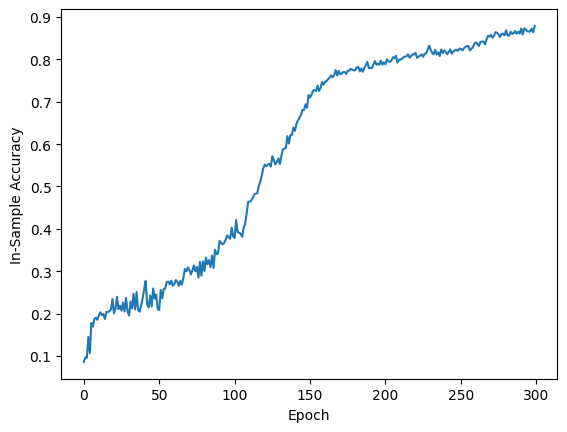

In [130]:
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("In-Sample Accuracy")
plt.show()

In [131]:
predictions = []

for x in test_images:
    result = network.predict(x.flatten())
    predictions += [result]

LOGGER.info(f"accuracy on test set: {accuracy_score(test_labels, predictions)}")

2024-02-11 12:30:55 [info     ] accuracy on test set: 0.8593  


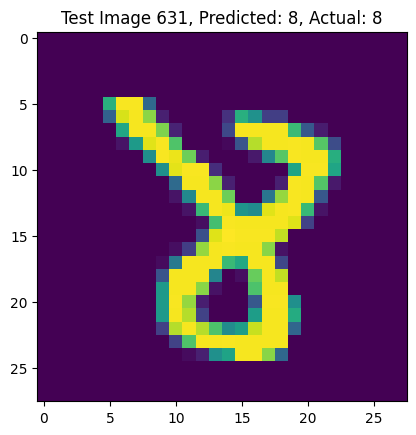

In [139]:
idx = 631
plt.imshow(test_images[idx])
plt.title(f"Test Image {idx}, Predicted: {predictions[idx]}, Actual: {test_labels[idx]}")
plt.show()